## S&P 500 Concentration Analysis: Data Retrieval & Visualization
# Analyzing whether the S&P 500 is too concentrated in its top holdings (Mag 7)


## Libraries & Setup

In [15]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


## 1. Data Collection


### Define Parameters

In [16]:
# Time period: 5 years of data (as of 10/16/25)
start_date = '2020-10-16'
end_date = '2025-10-16'

# Mag 7 tickers
mag7_tickers = ['NVDA', 'MSFT', 'AAPL', 'AMZN', 'META', 'GOOGL', 'TSLA']

# S&P 500 weightings (approximate as of late 2024/early 2025)
# Source: These are approximate based on market cap weightings
mag7_weights = {
    'NVDA': 6.8,    # Nvidia
    'AAPL': 6.5,    # Apple
    'MSFT': 6.3,    # Microsoft
    'AMZN': 3.8,    # Amazon
    'META': 2.8,    # Meta
    'GOOGL': 4.0,   # Alphabet (Google)
    'TSLA': 1.8     # Tesla
}

total_mag7_weight = sum(mag7_weights.values())
print(f"Total Mag 7 weight in S&P 500: {total_mag7_weight:.1f}%")


Total Mag 7 weight in S&P 500: 32.0%


### Stock Data Retrieval Function (Reused & Enhanced)

In [17]:
def get_stock_data(ticker, period_start, period_end):
    """
    Gets data for a particular stock using yFinance API.

    :param ticker: Stock ticker symbol
    :param period_start: Start date for data retrieval
    :param period_end: End date for data retrieval
    :return: pandas DataFrame of stock data
    """
    try:
        data = yf.download(ticker, start=period_start, end=period_end, progress=False)
        if data.empty:
            print(f"Warning: No data retrieved for {ticker}")
            return None
        return data
    except Exception as e:
        print(f"Error retrieving data for {ticker}: {e}")
        return None

def get_multiple_stocks(tickers, period_start, period_end):
    """
    Gets data for multiple stocks and stores in a dictionary.

    :param tickers: List of stock ticker symbols
    :param period_start: Start date
    :param period_end: End date
    :return: Dictionary of DataFrames
    """
    stock_data = {}
    for ticker in tickers:
        print(f"Downloading {ticker}...")
        data = get_stock_data(ticker, period_start, period_end)
        if data is not None:
            stock_data[ticker] = data
    return stock_data


### Download All Data

In [18]:
# Get S&P 500 data
print("Downloading S&P 500 (^GSPC)...")
sp500_data = yf.download('^GSPC', start=start_date, end=end_date, progress=False)

# Get Mag 7 data
print("\nDownloading Mag 7 stocks...")
mag7_data = get_multiple_stocks(mag7_tickers, start_date, end_date)

print("\nData download complete!")
print(f"S&P 500 data shape: {sp500_data.shape}")
print(f"Mag 7 stocks retrieved: {list(mag7_data.keys())}")




Data download complete!
S&P 500 data shape: (1255, 5)
Mag 7 stocks retrieved: ['NVDA', 'MSFT', 'AAPL', 'AMZN', 'META', 'GOOGL', 'TSLA']


## 2. Data Cleaning & Processing


### Check for Missing Data

In [19]:
def check_missing_data(data_dict):
    """
    Checks for missing values in multiple dataframes.

    :param data_dict: Dictionary of DataFrames
    :return: Summary of missing data
    """
    missing_summary = {}
    for ticker, df in data_dict.items():
        missing_count = df.isnull().sum().sum()
        missing_summary[ticker] = missing_count
    return missing_summary

# Check S&P 500
print("S&P 500 missing values:")
print(sp500_data.isnull().sum())

# Check Mag 7
print("\nMag 7 missing values:")
missing_mag7 = check_missing_data(mag7_data)
for ticker, count in missing_mag7.items():
    if count > 0:
        print(f"{ticker}: {count} missing values")

if all(count == 0 for count in missing_mag7.values()) and sp500_data.isnull().sum().sum() == 0:
    print("\n✓ No missing data found!")


S&P 500 missing values:
Price   Ticker
Close   ^GSPC     0
High    ^GSPC     0
Low     ^GSPC     0
Open    ^GSPC     0
Volume  ^GSPC     0
dtype: int64

Mag 7 missing values:

✓ No missing data found!


### Calculate Daily Returns

In [20]:
def calculate_returns(df):
    """
    Calculate daily returns for a stock.

    :param df: DataFrame with 'Close' column
    :return: Series of daily returns
    """
    return df['Close'].pct_change()

# Calculate returns for S&P 500
sp500_data['Daily_Return'] = calculate_returns(sp500_data)

# Calculate returns for Mag 7
for ticker in mag7_data:
    mag7_data[ticker]['Daily_Return'] = calculate_returns(mag7_data[ticker])

print("Daily returns calculated for all securities")


Daily returns calculated for all securities


### Create Combined Returns DataFrame

In [21]:
# Create a single DataFrame with all returns for easy analysis
returns_df = pd.DataFrame()
returns_df['SPY'] = sp500_data['Daily_Return']

for ticker in mag7_tickers:
    if ticker in mag7_data:
        returns_df[ticker] = mag7_data[ticker]['Daily_Return']

# Drop NaN values (first day will be NaN)
returns_df = returns_df.dropna()

print(f"\nCombined returns DataFrame shape: {returns_df.shape}")
print(f"Date range: {returns_df.index[0]} to {returns_df.index[-1]}")
print(f"\nFirst few rows:")
print(returns_df.head())



Combined returns DataFrame shape: (1254, 8)
Date range: 2020-10-19 00:00:00 to 2025-10-15 00:00:00

First few rows:
                 SPY      NVDA      MSFT      AAPL      AMZN      META  \
Date                                                                     
2020-10-19 -0.016330 -0.022717 -0.024765 -0.025542 -0.020014 -0.017035   
2020-10-20  0.004727  0.010946  0.002007  0.013192  0.003056  0.023565   
2020-10-21 -0.002196 -0.008849  0.000699 -0.005446 -0.009969  0.041748   
2020-10-22  0.005219 -0.012108  0.000419 -0.009583 -0.002681 -0.002188   
2020-10-23  0.003446  0.017158  0.006235 -0.006134  0.008815  0.023983   

               GOOGL      TSLA  
Date                            
2020-10-19 -0.024080 -0.020106  
2020-10-20  0.013811 -0.020635  
2020-10-21  0.022507  0.001659  
2020-10-22  0.013033  0.007453  
2020-10-23  0.016382 -0.012119  


### Calculate Correlation with S&P 500

In [22]:
# Calculate correlation of each Mag 7 stock with S&P 500
correlations = {}
for ticker in mag7_tickers:
    if ticker in returns_df.columns:
        corr = returns_df['SPY'].corr(returns_df[ticker])
        correlations[ticker] = corr

# Create correlation DataFrame with weights
correlation_df = pd.DataFrame({
    'Ticker': list(correlations.keys()),
    'Correlation_with_SPY': list(correlations.values()),
    'SP500_Weight_%': [mag7_weights[t] for t in correlations.keys()]
})

correlation_df = correlation_df.sort_values('Correlation_with_SPY', ascending=False)
print("\nCorrelation of Mag 7 stocks with S&P 500:")
print(correlation_df.to_string(index=False))



Correlation of Mag 7 stocks with S&P 500:
Ticker  Correlation_with_SPY  SP500_Weight_%
  MSFT              0.765861             6.3
  AAPL              0.755838             6.5
  AMZN              0.713871             3.8
  NVDA              0.697186             6.8
 GOOGL              0.695279             4.0
  META              0.628355             2.8
  TSLA              0.559229             1.8


### Calculate Cumulative Returns

In [23]:
def calculate_cumulative_returns(returns_series):
    """
    Calculate cumulative returns from daily returns.

    :param returns_series: Series of daily returns
    :return: Series of cumulative returns
    """
    return (1 + returns_series).cumprod() - 1

# Calculate cumulative returns for all securities
cumulative_returns = pd.DataFrame()
cumulative_returns['SPY'] = calculate_cumulative_returns(returns_df['SPY'])

for ticker in mag7_tickers:
    if ticker in returns_df.columns:
        cumulative_returns[ticker] = calculate_cumulative_returns(returns_df[ticker])

# Create a weighted Mag 7 index
mag7_weighted_returns = pd.Series(0, index=returns_df.index)
for ticker in mag7_tickers:
    if ticker in returns_df.columns:
        weight = mag7_weights[ticker] / 100  # Convert percentage to decimal
        mag7_weighted_returns += returns_df[ticker] * weight

cumulative_returns['Mag7_Weighted'] = calculate_cumulative_returns(mag7_weighted_returns)

print("\nCumulative returns calculated")
print(f"Final 5-year returns:")
print(f"S&P 500: {cumulative_returns['SPY'].iloc[-1]*100:.2f}%")
print(f"Weighted Mag 7: {cumulative_returns['Mag7_Weighted'].iloc[-1]*100:.2f}%")



Cumulative returns calculated
Final 5-year returns:
S&P 500: 91.49%
Weighted Mag 7: 62.27%


## 3. Visualizations


### Visualization 1: Correlation Heatmap with Weights

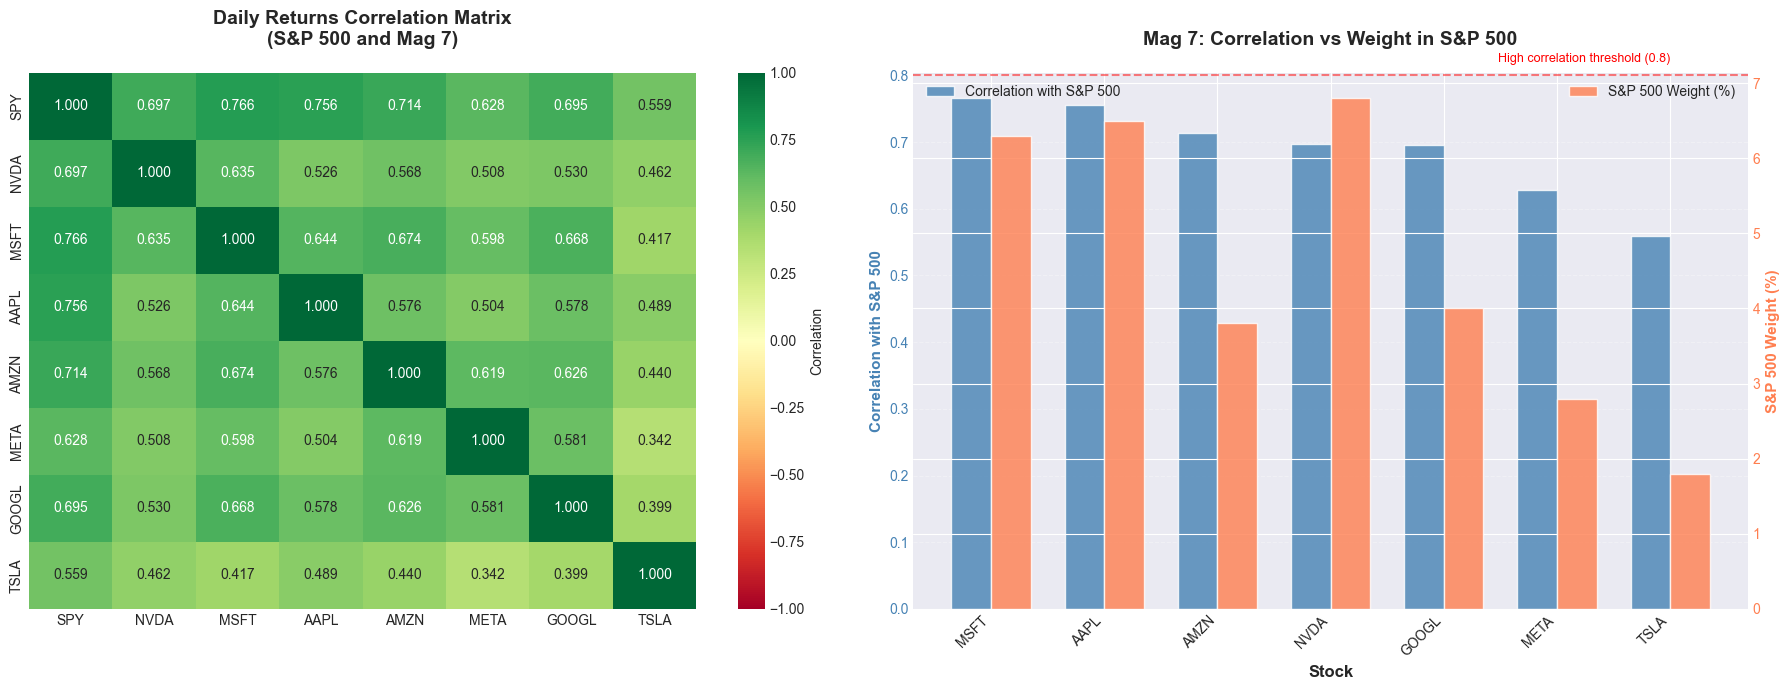


📊 KEY INSIGHTS FROM CORRELATION ANALYSIS:
Average correlation of Mag 7 with S&P 500: 0.688
Stocks with correlation > 0.8: 0 out of 7
Combined weight of Mag 7 in S&P 500: 32.0%


In [24]:
# Create correlation matrix for all stocks
correlation_matrix = returns_df.corr()

# Create a more informative visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Left plot: Full correlation heatmap
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='RdYlGn',
            center=0, vmin=-1, vmax=1, ax=ax1, cbar_kws={'label': 'Correlation'})
ax1.set_title('Daily Returns Correlation Matrix\n(S&P 500 and Mag 7)',
              fontsize=14, fontweight='bold', pad=20)
ax1.set_xlabel('')
ax1.set_ylabel('')

# Right plot: Bar chart showing correlation with S&P 500 and weights
x_pos = np.arange(len(correlation_df))
width = 0.35

# Create bars
bars1 = ax2.bar(x_pos - width/2, correlation_df['Correlation_with_SPY'],
                width, label='Correlation with S&P 500', color='steelblue', alpha=0.8)
ax2_twin = ax2.twinx()
bars2 = ax2_twin.bar(x_pos + width/2, correlation_df['SP500_Weight_%'],
                     width, label='S&P 500 Weight (%)', color='coral', alpha=0.8)

# Formatting
ax2.set_xlabel('Stock', fontsize=12, fontweight='bold')
ax2.set_ylabel('Correlation with S&P 500', fontsize=11, fontweight='bold', color='steelblue')
ax2_twin.set_ylabel('S&P 500 Weight (%)', fontsize=11, fontweight='bold', color='coral')
ax2.set_title('Mag 7: Correlation vs Weight in S&P 500',
              fontsize=14, fontweight='bold', pad=20)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(correlation_df['Ticker'], rotation=45, ha='right')
ax2.tick_params(axis='y', labelcolor='steelblue')
ax2_twin.tick_params(axis='y', labelcolor='coral')
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.axhline(y=0.8, color='red', linestyle='--', alpha=0.5, linewidth=1.5)
ax2.text(len(correlation_df)-1, 0.82, 'High correlation threshold (0.8)',
         ha='right', fontsize=9, color='red')

# Add legends
ax2.legend(loc='upper left', framealpha=0.9)
ax2_twin.legend(loc='upper right', framealpha=0.9)

plt.tight_layout()
plt.savefig('mag7_correlation_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Print key insights
print("\n📊 KEY INSIGHTS FROM CORRELATION ANALYSIS:")
print(f"Average correlation of Mag 7 with S&P 500: {correlation_df['Correlation_with_SPY'].mean():.3f}")
print(f"Stocks with correlation > 0.8: {(correlation_df['Correlation_with_SPY'] > 0.8).sum()} out of {len(correlation_df)}")
print(f"Combined weight of Mag 7 in S&P 500: {correlation_df['SP500_Weight_%'].sum():.1f}%")


### Visualization 2: Cumulative Returns Comparison

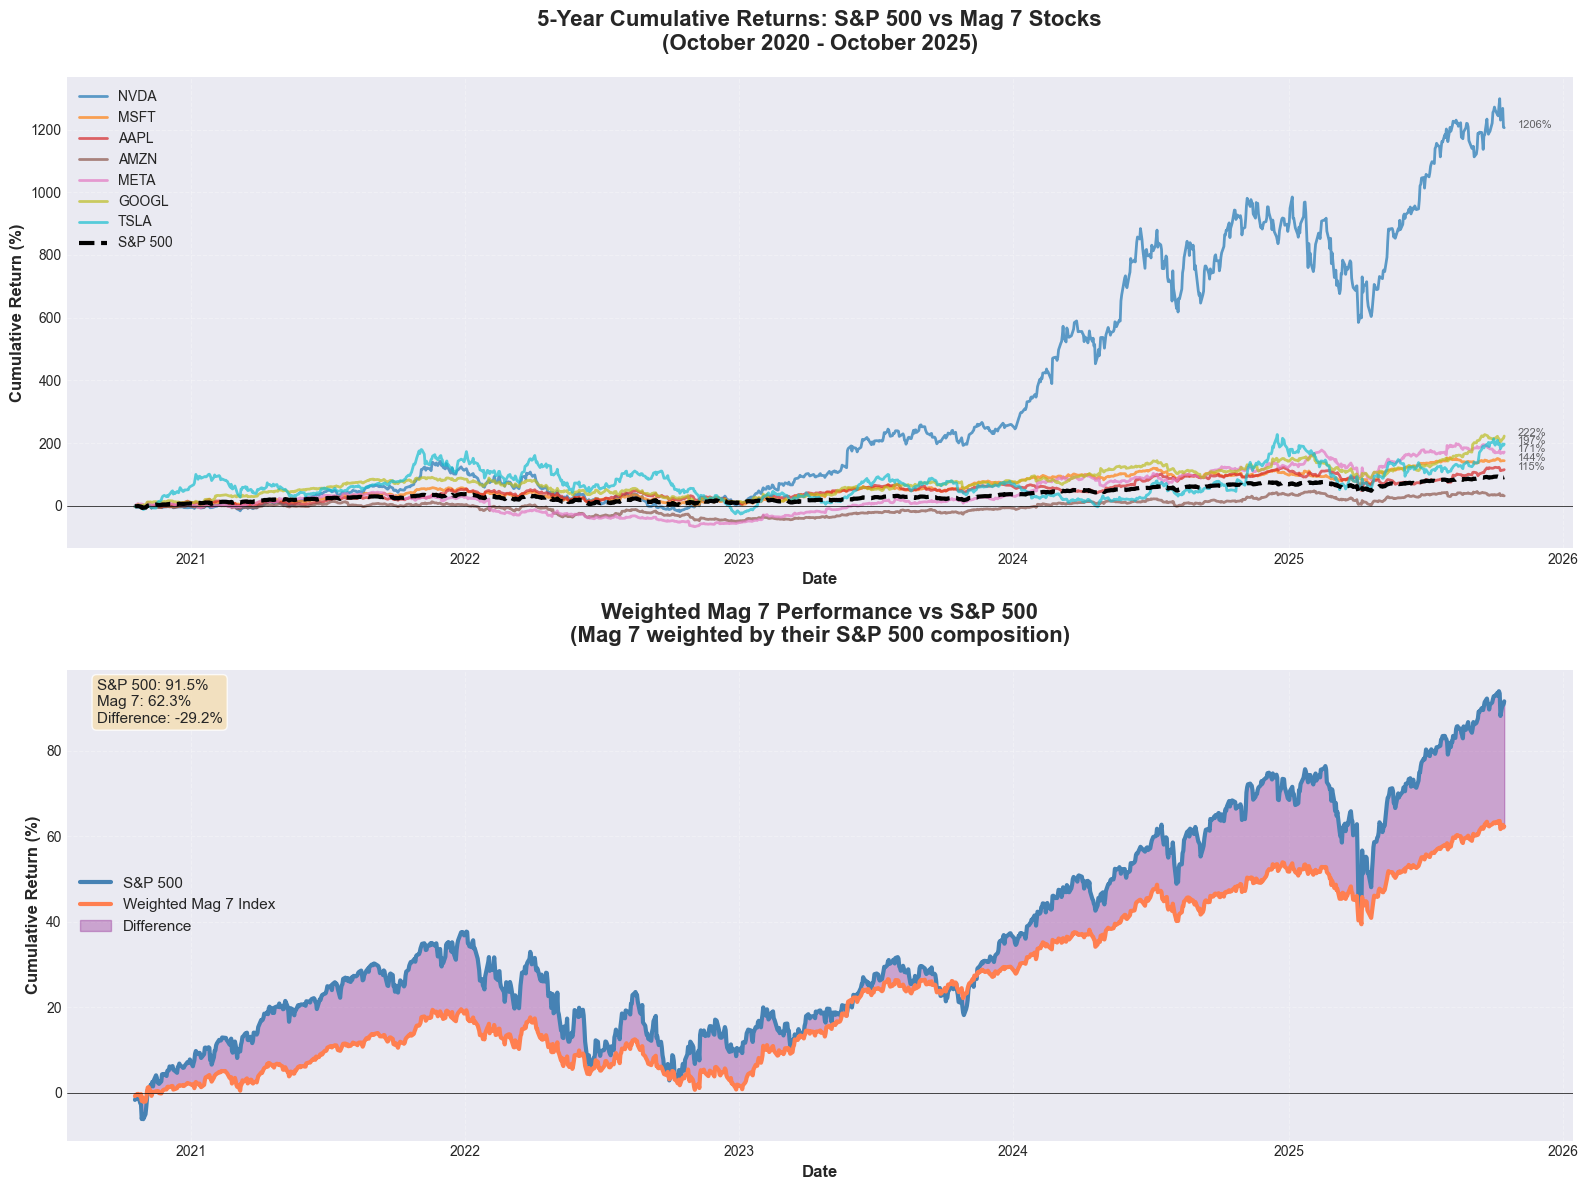


📈 CUMULATIVE RETURNS SUMMARY:
S&P 500: 91.49%
Weighted Mag 7: 62.27%
Difference: -29.22%

Implication: The Mag 7 (at 32.0% of S&P 500) underperformed by 29.22%


In [25]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

# Top plot: All stocks vs S&P 500
colors = plt.cm.tab10(np.linspace(0, 1, len(mag7_tickers)))
for i, ticker in enumerate(mag7_tickers):
    if ticker in cumulative_returns.columns:
        ax1.plot(cumulative_returns.index, cumulative_returns[ticker] * 100,
                label=ticker, linewidth=2, alpha=0.7, color=colors[i])

ax1.plot(cumulative_returns.index, cumulative_returns['SPY'] * 100,
        label='S&P 500', linewidth=3, color='black', linestyle='--')

ax1.set_title('5-Year Cumulative Returns: S&P 500 vs Mag 7 Stocks\n(October 2020 - October 2025)',
             fontsize=16, fontweight='bold', pad=20)
ax1.set_xlabel('Date', fontsize=12, fontweight='bold')
ax1.set_ylabel('Cumulative Return (%)', fontsize=12, fontweight='bold')
ax1.legend(loc='best', framealpha=0.9, fontsize=10)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Add annotations for final returns
for ticker in mag7_tickers:
    if ticker in cumulative_returns.columns:
        final_return = cumulative_returns[ticker].iloc[-1] * 100
        if final_return > 100:  # Only annotate stocks with >100% returns
            ax1.annotate(f'{final_return:.0f}%',
                        xy=(cumulative_returns.index[-1], final_return),
                        xytext=(10, 0), textcoords='offset points',
                        fontsize=8, alpha=0.7)

# Bottom plot: Weighted Mag 7 vs S&P 500 (closer comparison)
ax2.plot(cumulative_returns.index, cumulative_returns['SPY'] * 100,
        label='S&P 500', linewidth=3, color='steelblue')
ax2.plot(cumulative_returns.index, cumulative_returns['Mag7_Weighted'] * 100,
        label='Weighted Mag 7 Index', linewidth=3, color='coral')

# Fill the area between the two lines
ax2.fill_between(cumulative_returns.index,
                 cumulative_returns['SPY'] * 100,
                 cumulative_returns['Mag7_Weighted'] * 100,
                 alpha=0.3, color='purple',
                 label='Difference')

ax2.set_title('Weighted Mag 7 Performance vs S&P 500\n(Mag 7 weighted by their S&P 500 composition)',
             fontsize=16, fontweight='bold', pad=20)
ax2.set_xlabel('Date', fontsize=12, fontweight='bold')
ax2.set_ylabel('Cumulative Return (%)', fontsize=12, fontweight='bold')
ax2.legend(loc='best', framealpha=0.9, fontsize=11)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Add final return annotations
sp500_final = cumulative_returns['SPY'].iloc[-1] * 100
mag7_final = cumulative_returns['Mag7_Weighted'].iloc[-1] * 100
difference = mag7_final - sp500_final

ax2.text(0.02, 0.98,
        f'S&P 500: {sp500_final:.1f}%\nMag 7: {mag7_final:.1f}%\nDifference: {difference:.1f}%',
        transform=ax2.transAxes, fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.savefig('mag7_cumulative_returns.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\n📈 CUMULATIVE RETURNS SUMMARY:")
print(f"S&P 500: {sp500_final:.2f}%")
print(f"Weighted Mag 7: {mag7_final:.2f}%")
print(f"Difference: {difference:.2f}%")
print(f"\nImplication: The Mag 7 (at {total_mag7_weight:.1f}% of S&P 500) {'outperformed' if difference > 0 else 'underperformed'} by {abs(difference):.2f}%")


### Additional Analysis: Rolling Correlation

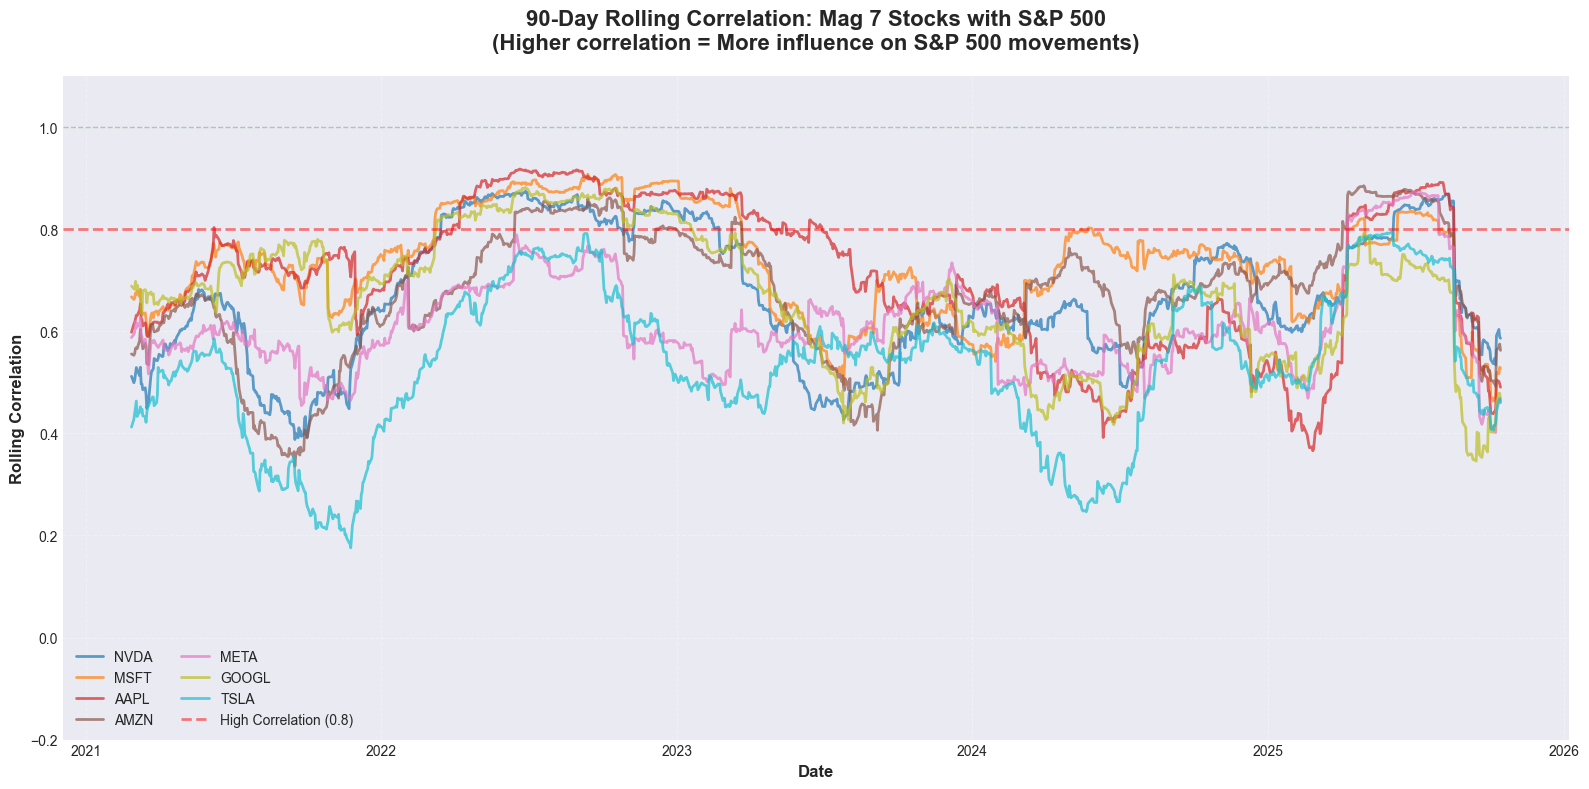


📊 ROLLING CORRELATION INSIGHTS:
Recent average correlation (last 90 days): 0.685


In [26]:
# Calculate 90-day rolling correlation
rolling_window = 90
rolling_corr = pd.DataFrame(index=returns_df.index)

for ticker in mag7_tickers:
    if ticker in returns_df.columns:
        rolling_corr[ticker] = returns_df['SPY'].rolling(window=rolling_window).corr(returns_df[ticker])

# Plot rolling correlations
fig, ax = plt.subplots(figsize=(16, 8))

colors = plt.cm.tab10(np.linspace(0, 1, len(mag7_tickers)))
for i, ticker in enumerate(mag7_tickers):
    if ticker in rolling_corr.columns:
        ax.plot(rolling_corr.index, rolling_corr[ticker],
               label=ticker, linewidth=2, alpha=0.7, color=colors[i])

ax.axhline(y=0.8, color='red', linestyle='--', linewidth=2, alpha=0.5, label='High Correlation (0.8)')
ax.axhline(y=1.0, color='green', linestyle='--', linewidth=1, alpha=0.3)
ax.set_title(f'{rolling_window}-Day Rolling Correlation: Mag 7 Stocks with S&P 500\n(Higher correlation = More influence on S&P 500 movements)',
            fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Rolling Correlation', fontsize=12, fontweight='bold')
ax.legend(loc='best', framealpha=0.9, ncol=2)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_ylim(-0.2, 1.1)

plt.tight_layout()
plt.savefig('mag7_rolling_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n📊 ROLLING CORRELATION INSIGHTS:")
print(f"Recent average correlation (last 90 days): {rolling_corr.iloc[-90:].mean().mean():.3f}")


## Summary Statistics

In [27]:
# Create summary table
summary_stats = pd.DataFrame({
    'Ticker': ['SPY'] + mag7_tickers,
    'Avg_Daily_Return_%': [returns_df[col].mean() * 100 for col in ['SPY'] + mag7_tickers if col in returns_df.columns],
    'Volatility_%': [returns_df[col].std() * 100 for col in ['SPY'] + mag7_tickers if col in returns_df.columns],
    'Sharpe_Ratio': [(returns_df[col].mean() / returns_df[col].std()) * np.sqrt(252) for col in ['SPY'] + mag7_tickers if col in returns_df.columns],
    'Total_Return_%': [cumulative_returns[col].iloc[-1] * 100 for col in ['SPY'] + mag7_tickers if col in cumulative_returns.columns]
})

print("\n📋 SUMMARY STATISTICS (5-Year Period):")
print(summary_stats.to_string(index=False))

# Save to CSV
summary_stats.to_csv('mag7_summary_statistics.csv', index=False)
print("\n✓ Summary statistics saved to 'mag7_summary_statistics.csv'")



📋 SUMMARY STATISTICS (5-Year Period):
Ticker  Avg_Daily_Return_%  Volatility_%  Sharpe_Ratio  Total_Return_%
   SPY            0.057622      1.078103      0.848451       91.487479
  NVDA            0.258802      3.294478      1.247041     1206.005597
  MSFT            0.084416      1.635399      0.819414      143.775878
  AAPL            0.077164      1.791698      0.683678      115.369980
  AMZN            0.046317      2.206935      0.333157       31.737924
  META            0.117738      2.745646      0.680727      171.490049
 GOOGL            0.112496      1.955690      0.913139      222.461404
  TSLA            0.160831      3.862290      0.661037      196.915855

✓ Summary statistics saved to 'mag7_summary_statistics.csv'


## Conclusion

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)
print(f"""
This analysis examined the concentration risk in the S&P 500 by analyzing the
Magnificent 7 stocks, which collectively represent {total_mag7_weight:.1f}% of the index.

Key Findings:
1. High Correlation: The Mag 7 show an average correlation of {correlation_df['Correlation_with_SPY'].mean():.3f}
   with the S&P 500, indicating their movements strongly influence the index.

2. Outsized Returns: The weighted Mag 7 index returned {mag7_final:.1f}% over 5 years,
   compared to the S&P 500's {sp500_final:.1f}% return.

3. Concentration Risk: With just 7 companies comprising nearly one-third of the index,
   investors in "passive" S&P 500 funds are heavily exposed to these tech giants.

Next Steps: ML modeling to explore alternative weighting schemes that might better
represent broad market performance while reducing concentration risk.
""")